In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

%load_ext line_profiler
%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import yep

In [3]:
nst = 256
nsm = 256
nips = 4;
nrps = 4;
nb = 64
measperiod = 4;
nt = 32
nh = 2
ncores = 4
nmaxiter = 1
L = 12
J1 = 1
J2 = 0
h = 0
measupdate =True
p = 1
if not measupdate:
    p= 0

stroutput = "PSIMeasupdate_Opti3_J1={0}_J2={3}_L={1}_p={2}_central".format(J1,L,p,J2)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = 0.0,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test2_step1_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = measupdate, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--p', type = float, default = p, 
                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = True, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.0001,30],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = True, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--all_correlations', default = False, action = 'store_true',
                        help = '''activate if you want to save the correlations for all non-equivalent
                        pairs of sites. Otherwise, will save central correlations.''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose',default = False, action = 'store_true',
                        help = 'activate verbosity')
    args = parser.parse_args()
    return args
Jupyter Notebook
ProfilerTest_PSI_MeasurementUpdate (autosaved) Current Kernel Logo 

Python 3

    File
    Edit
    View
    Insert
    Cell
    Kernel
    Widgets
    Help

1

import os,sys,inspect

2

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

3

parentdir = os.path.dirname(currentdir)

4

sys.path.insert(0,parentdir)

1

import DualwormFunctions as dw

2

import Observables as obs

3

​

4

%load_ext line_profiler

5

%load_ext memory_profiler

6

​

7

import RunBasis

8

import argparse

9

import StartStates as strst

10

import numpy as np

11

​

12

import AnalysisFunctions as af # functions to make the analysis code cleaner

13

import KagomeDrawing as kdraw

14

    #plots using matplotlib

15

import matplotlib.pyplot as plt

16

%matplotlib inline

17

​

18

import yep

1

nst = 256

2

nsm = 256

3

nips = 4;

4

nrps = 4;

5

nb = 64

6

measperiod = 4;

7

nt = 32

8

nh = 2

9

ncores = 4

10

nmaxiter = 1

11

L = 12

12

J1 = 1

13

J2 = 0

14

h = 0

15

measupdate =True

16

p = 1

17

if not measupdate:

18

    p= 0

19

​

20

stroutput = "PSIMeasupdate_Opti3_J1={0}_J2={3}_L={1}_p={2}_central".format(J1,L,p,J2)

1

def genArgs():

2

    parser = argparse.ArgumentParser()

3

    

4

    parser.add_argument('-f', type = str)

5

​

6

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

7

​

8

    # COUPLINGS

9

    parser.add_argument('--J1', type = float, default = J1,

10

                        help = 'NN coupling') # nearest-neighbour coupling

11

    parser.add_argument('--J2', type = float, default = J2,

12

                        help = '2nd NN coupling') # 2nd NN coupling

13

    parser.add_argument('--J3', type = float, default = 0.0,

14

                        help = '3rd NN coupling') # 3rd NN coupling

15

    parser.add_argument('--J4', type = float, default = 0.0,

16

                        help = '4th NN coupling') 

17

    #NUMBER OF STEPS AND ITERATIONS

18

    parser.add_argument('--nst', type = int, default = nst,

19

                        help = 'number of thermalisation steps') # number of thermalisation steps

20

    parser.add_argument('--nsm', type = int, default = nsm,

21

                        help = 'number of measurements steps') # number of measurement steps

22

    parser.add_argument('--nips', type = int, default = nips,

23

                        help = 'number of worm constructions per MC step')

24

    parser.add_argument('--nrps', type = int, default = nrps,

25

                        help = 'number of replica loops per MC step')

26

    parser.add_argument('--measperiod', type = int, default = measperiod,

27

                        help = 'number of nips worm building + swaps between measurements')

28

    parser.add_argument('--nb', type = int, default = nb,

29

                        help = 'number of bins')

30

​

31

    #PARALLELISATION

32

    parser.add_argument('--ncores', type = int, default = ncores,

33

                        help = 'number of threads to use')

34

​

35

    

36

    # INITIALISATION PARAMETERS

37

    parser.add_argument('--randominit', default = True, action ='store_true',

38

                        help = 'intialise the states randomly')

39

    parser.add_argument('--same', default = False, action = 'store_true',

40

                        help = '''initialise all temperatures with the same

41

                        state (debug purposes)''')

42

    parser.add_argument('--magninit', default = False, action = 'store_true',

43

                        help = '''initialise all the temperature with

44

                        one of the m=1/3 GS''')

45

    parser.add_argument('--magnstripes', default = False, action = 'store_true',

46

                       help = '''initialise all the temperature with

47

                       m=1/3 stripes''')

48

    parser.add_argument('--maxflip', default = False, action = 'store_true',

49

                       help = '''initialise all the temperature with

50

                       maximally flippable plateau''')

51

    parser.add_argument('--loadfromfile', default = False, action = 'store_true',

52

                       help = '''initialise all the states with

53

                       results from a previously performed simulations''')

54

    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test2_step1_folder',

55

                       help = '''initialise all the states with

56

                       results from a previously performed simulations''')

57

    

58

    #WORM PARAMETERS

59

    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,

60

                        help = '''maximal number of segments in a loop update over the

61

                        size of the lattice (1 = 1times the number of dualbonds in the

62

                        lattice)''')

63

    parser.add_argument('--measupdate', default = measupdate, action = 'store_true',

64

                       help = '''activate to mimic the action of the measuring tip''')

65

    parser.add_argument('--p', type = float, default = p, 

66

                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')

67

    parser.add_argument('--ssf', default = False, action = 'store_true',

68

                        help = 'activate for single spin flip update')

69

    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',

70

                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')

71

    parser.add_argument('--alternate', default = True, action = 'store_true',

72

                        help = 'activate for single spin flip update and dw update')

73

    parser.add_argument('--checkgs', default = True, action = 'store_true',

74

                        help = 'activate to debug ssf')

75

    

76

    #TEMPERATURE PARAMETERS

77

    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.0001,30],

78

                        help = 'list of limiting temperature values')

79

    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],

80

                        help = 'list of number of temperatures in between the given limiting temperatures')

81

    parser.add_argument('--log_tlist', default = True, action='store_true',

82

                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')

83

    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,

84

                        help = '''limiting temperatures for the various ranges of

85

                        measurements''') 

86

                        #default will be set to none, and then we can decide what to do later on.

87

    #MAGNETIC FIELD PARAMETERS

88

    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,

89

                        help = 'list of limiting magnetic field values')

90

    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,

91

                        help = 'list of number of magnetic fields in between the given limiting temperatures')

92

    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,

93

                help = '''limiting magnetic fields for the various ranges of

94

                measurements''') 

95

    #MEASUREMENTS PARAMETERS

96

    parser.add_argument('--generatingMode', default = False, action = 'store_true',

97

                        help = 'activate if you want to generate a number of ground states and low energy states')

98

    parser.add_argument('--energy', default = True, action = 'store_true',

99

                        help = 'activate if you want to save the energy')

100

    parser.add_argument('--magnetisation', default = True, action = 'store_true',

101

                        help = 'activate if you want to save the magnetisation')

102

    parser.add_argument('--charges', default = True, action = 'store_true',

103

                        help = 'activate if you want to save the charges')

104

    parser.add_argument('--correlations', default = True, action = 'store_true',

105

                        help = 'activate if you want to save either central or all correlations')

106

    parser.add_argument('--all_correlations', default = False, action = 'store_true',

107

                        help = '''activate if you want to save the correlations for all non-equivalent

108

                        pairs of sites. Otherwise, will save central correlations.''')

109

    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',

110

                        help = 'activate if you want to save first correlations, otherwise will save central')

111

    #SAVE

112

    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')

113

    parser.add_argument('--verbose',default = False, action = 'store_true',

114

                        help = 'activate verbosity')

115

    args = parser.parse_args()

116

    return args

1

def callRunBasis():

2

    args = genArgs()

3

    return RunBasis.main(args)

1

#%%prun -s  -T prun0

2

#yep.start(stroutput+'.log')

3

%lprun -f dw.mcs_swaps [meanstat, swapst, swapsh, failedupdatesth, failedupdates] = callRunBasis()

4

#yep.stop()

-------------------Initialisation--------------------

In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
%lprun -f dw.mcs_swaps [meanstat, swapst, swapsh, failedupdatesth, failedupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./PSIMeasupdate_Opti3_J1=1_J2=0_L=12_p=1_central_folder/backup.hkl
Lattice side size:  12
J1  1
J2  0
J3  0.0
J3st  0.0
Couplings extracted
Hamiltonian expression (without field) computed
alternating ssf and dw update
Number of temperatures:  32
Temperatures: [1.00000000e-04 1.50203942e-04 2.25612242e-04 3.38878482e-04
 5.09008838e-04 7.64551340e-04 1.14838625e-03 1.72492142e-03
 2.59089997e-03 3.89163389e-03 5.84538752e-03 8.78000248e-03
 1.31879098e-02 1.98087605e-02 2.97535391e-02 4.46909886e-02
 6.71276267e-02 1.00828341e-01 1.51448144e-01 2.27481082e-01
 3.41685553e-01 5.13225169e-01 7.70884436e-01 1.15789881e+00
 1.73920966e+00 2.61236147e+00 3.92386991e+00 5.89380729e+00
 8.85273089e+00 1.32971508e+01 1.99728446e+01 3.00000000e+01]
Number of magnetic fields:  1
Magnetic fields:  [0.]
Fully random initialisation =  True
Identical initialisation =  False
Magnetisation initialisation =  False
Minimal energy index:  0  with energ

In [7]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [8]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh,
 stat_hfields, hfields_plots, listfunctions, sref, idswalker] =\
af.LoadParameters(foldername, filenamelist)

[-0.66666667]


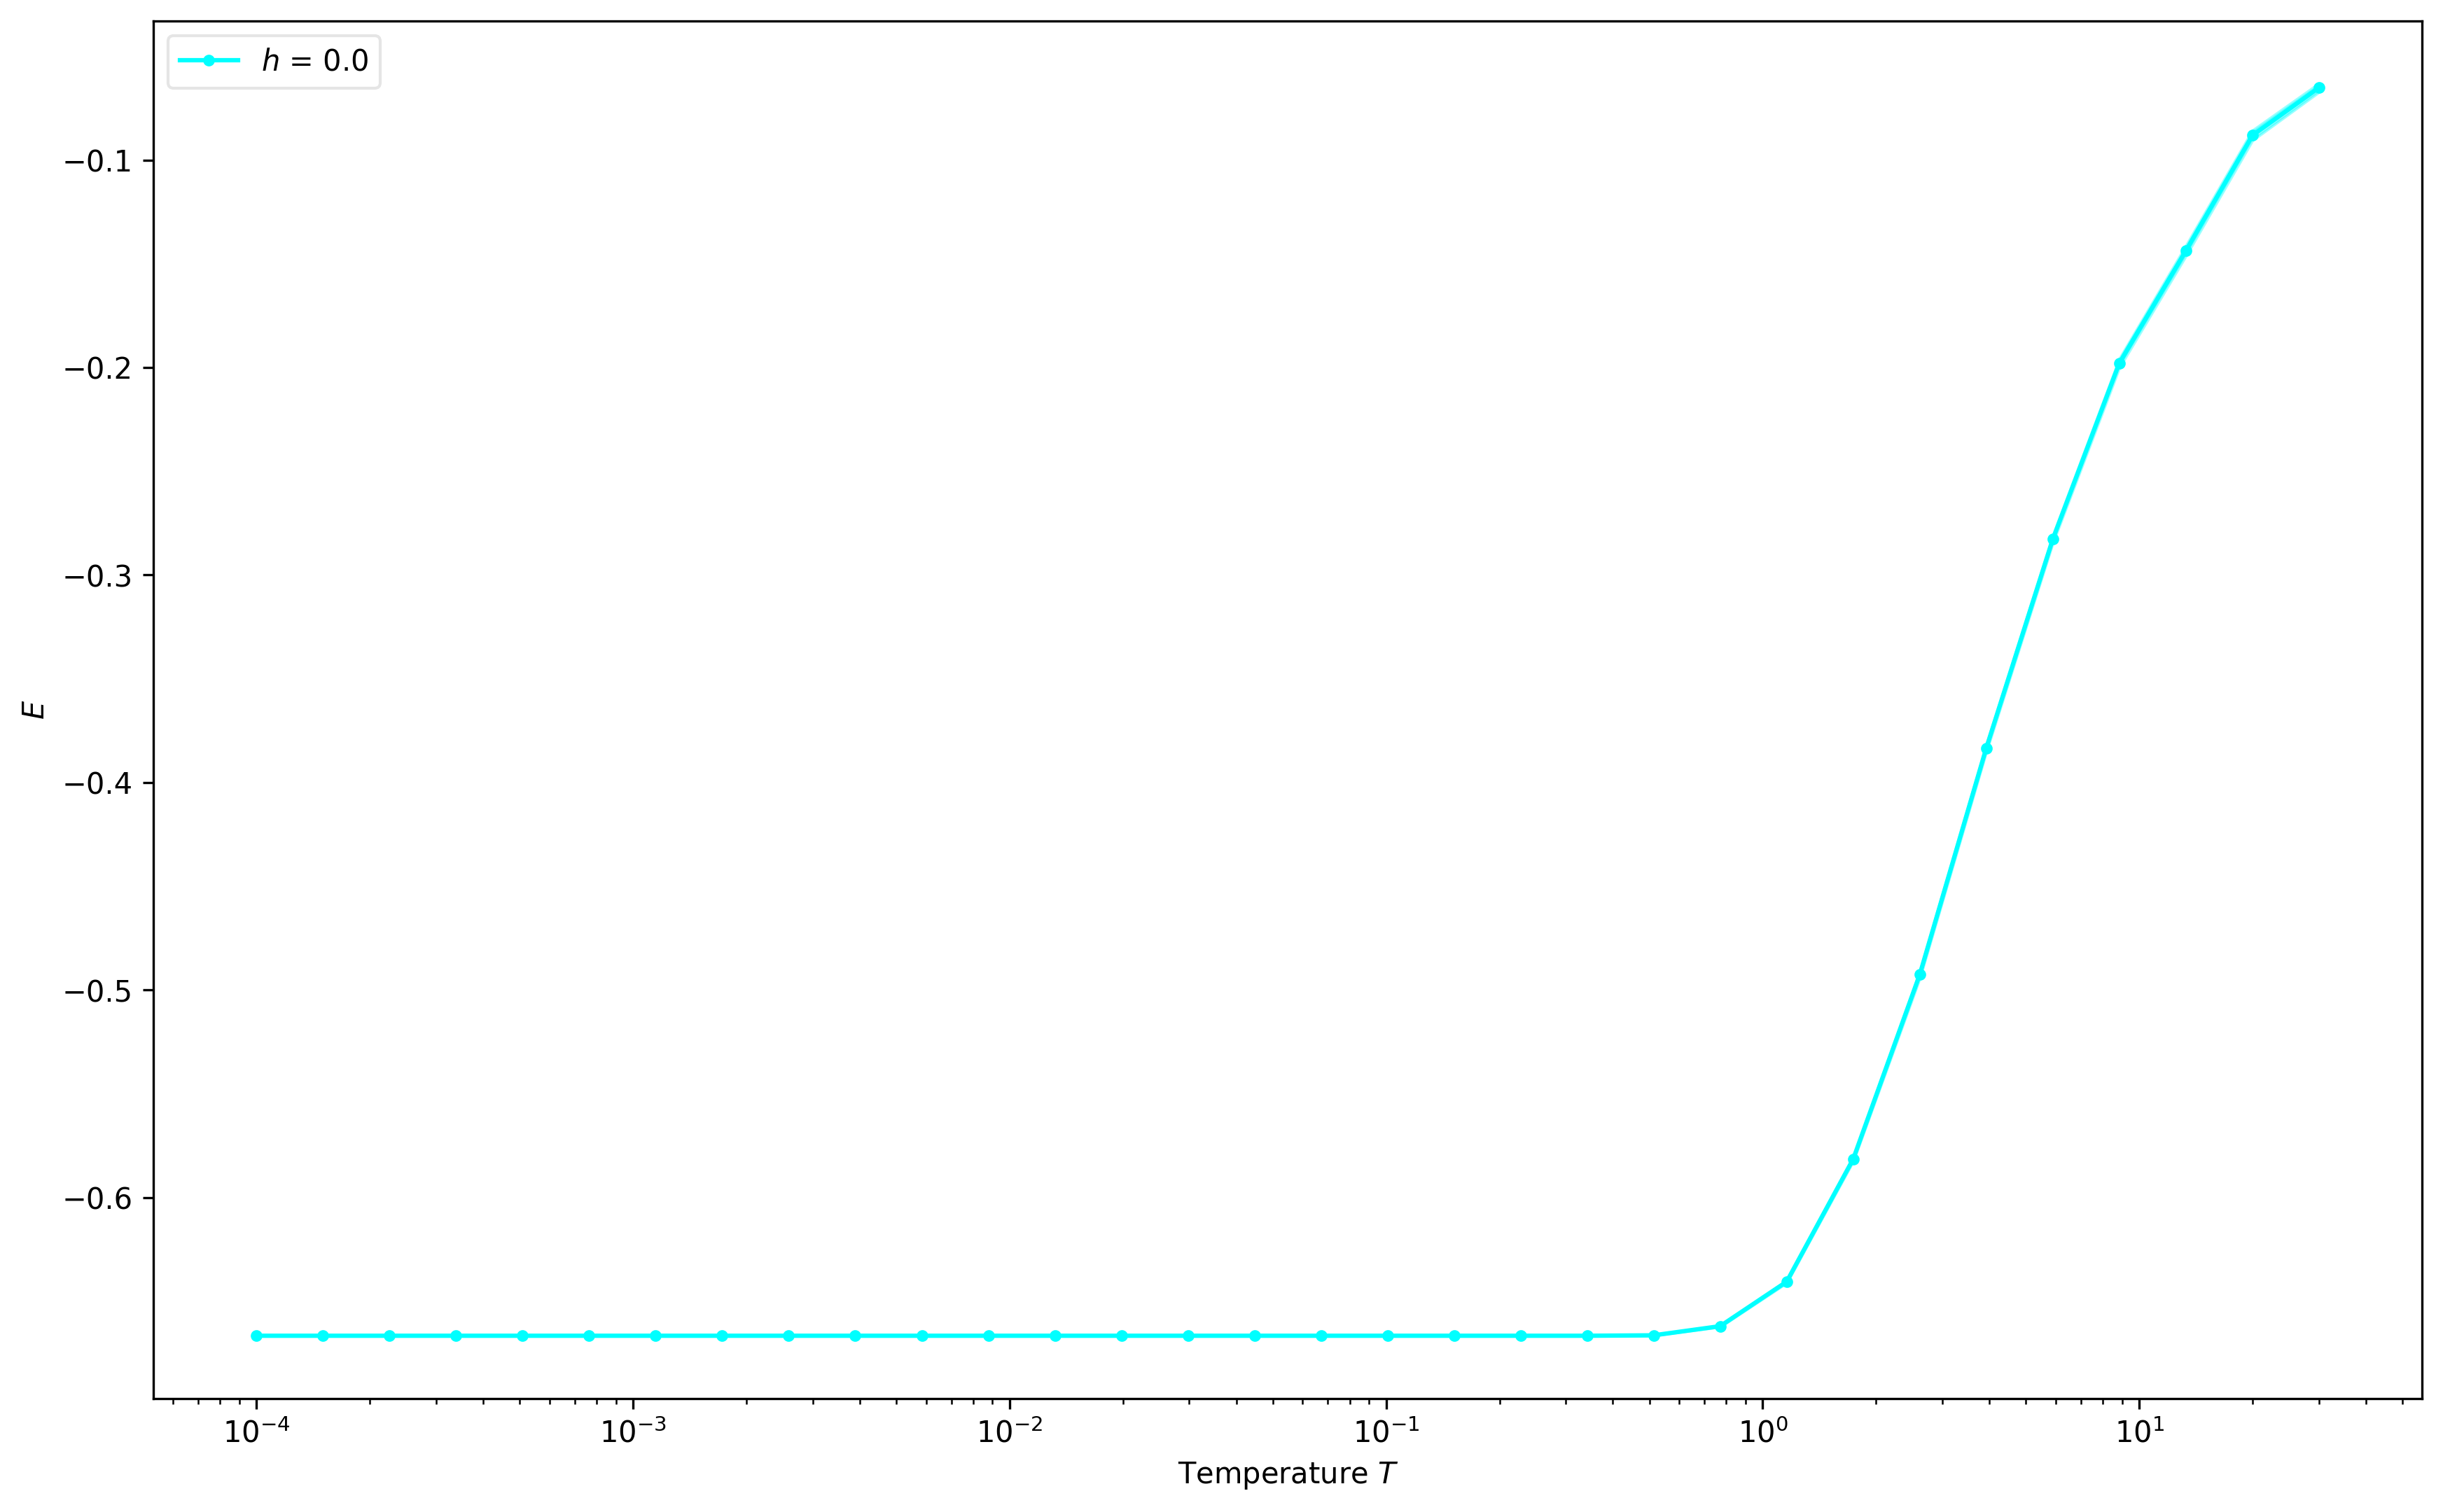

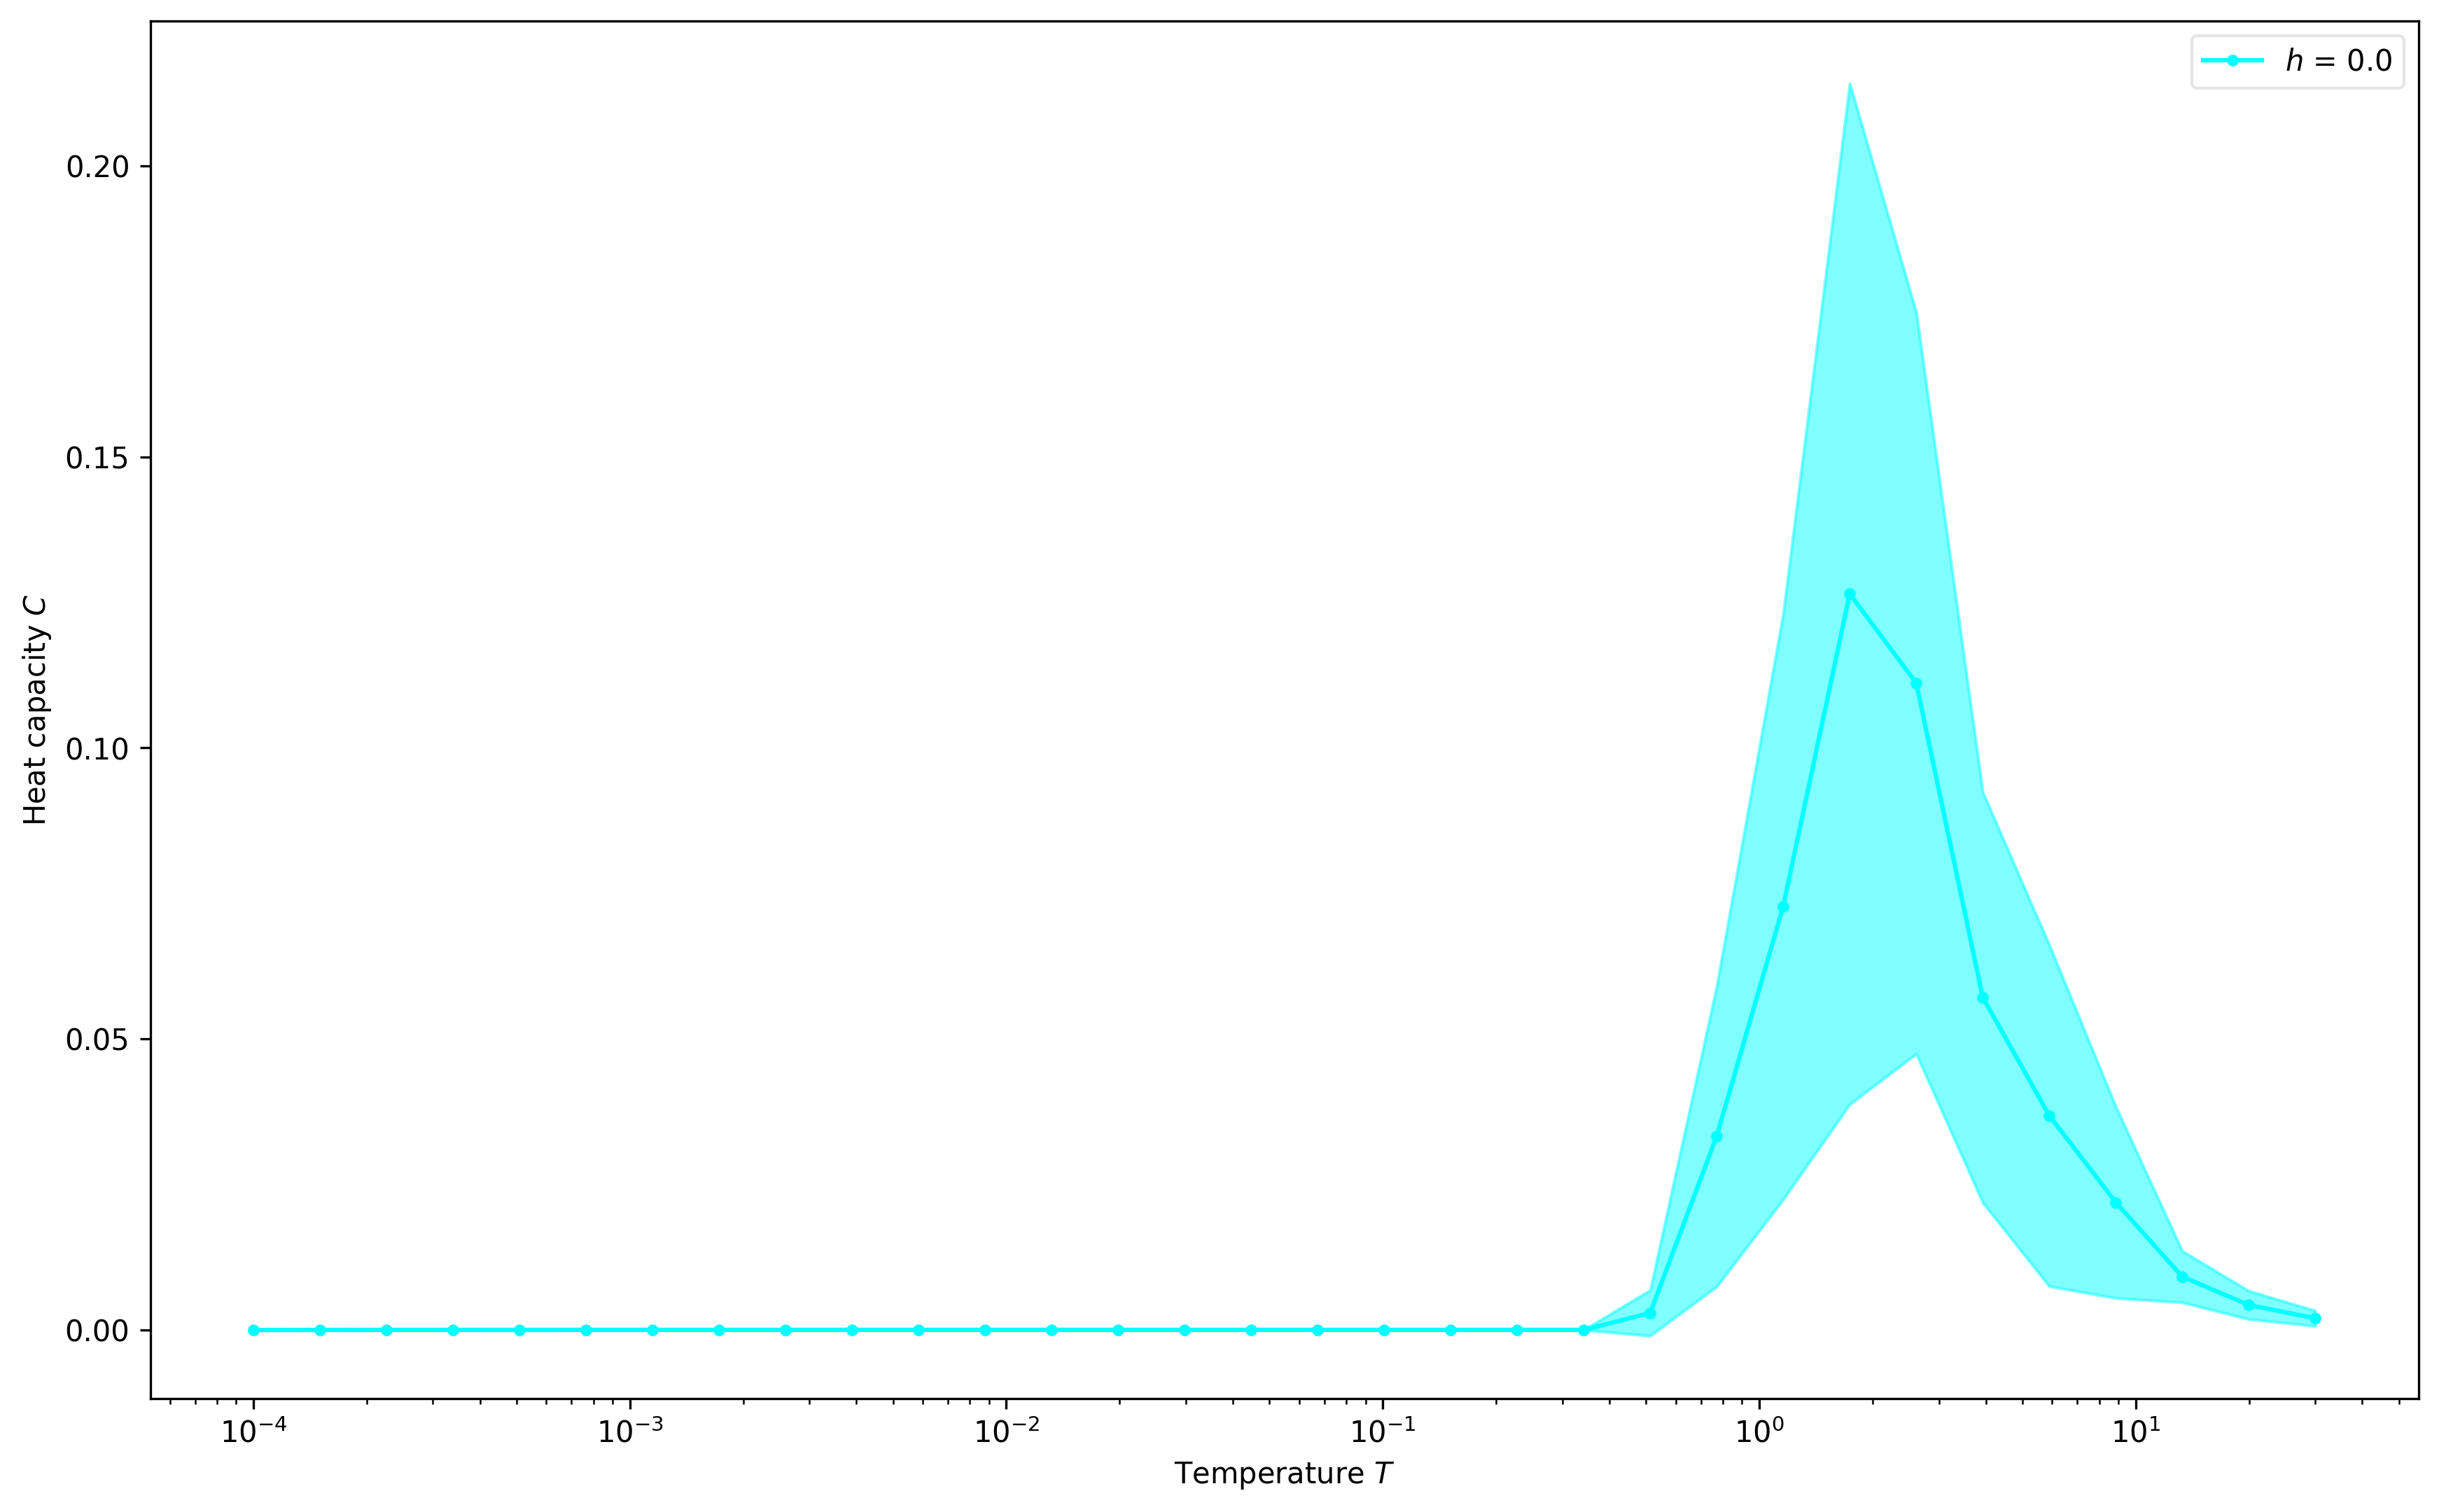

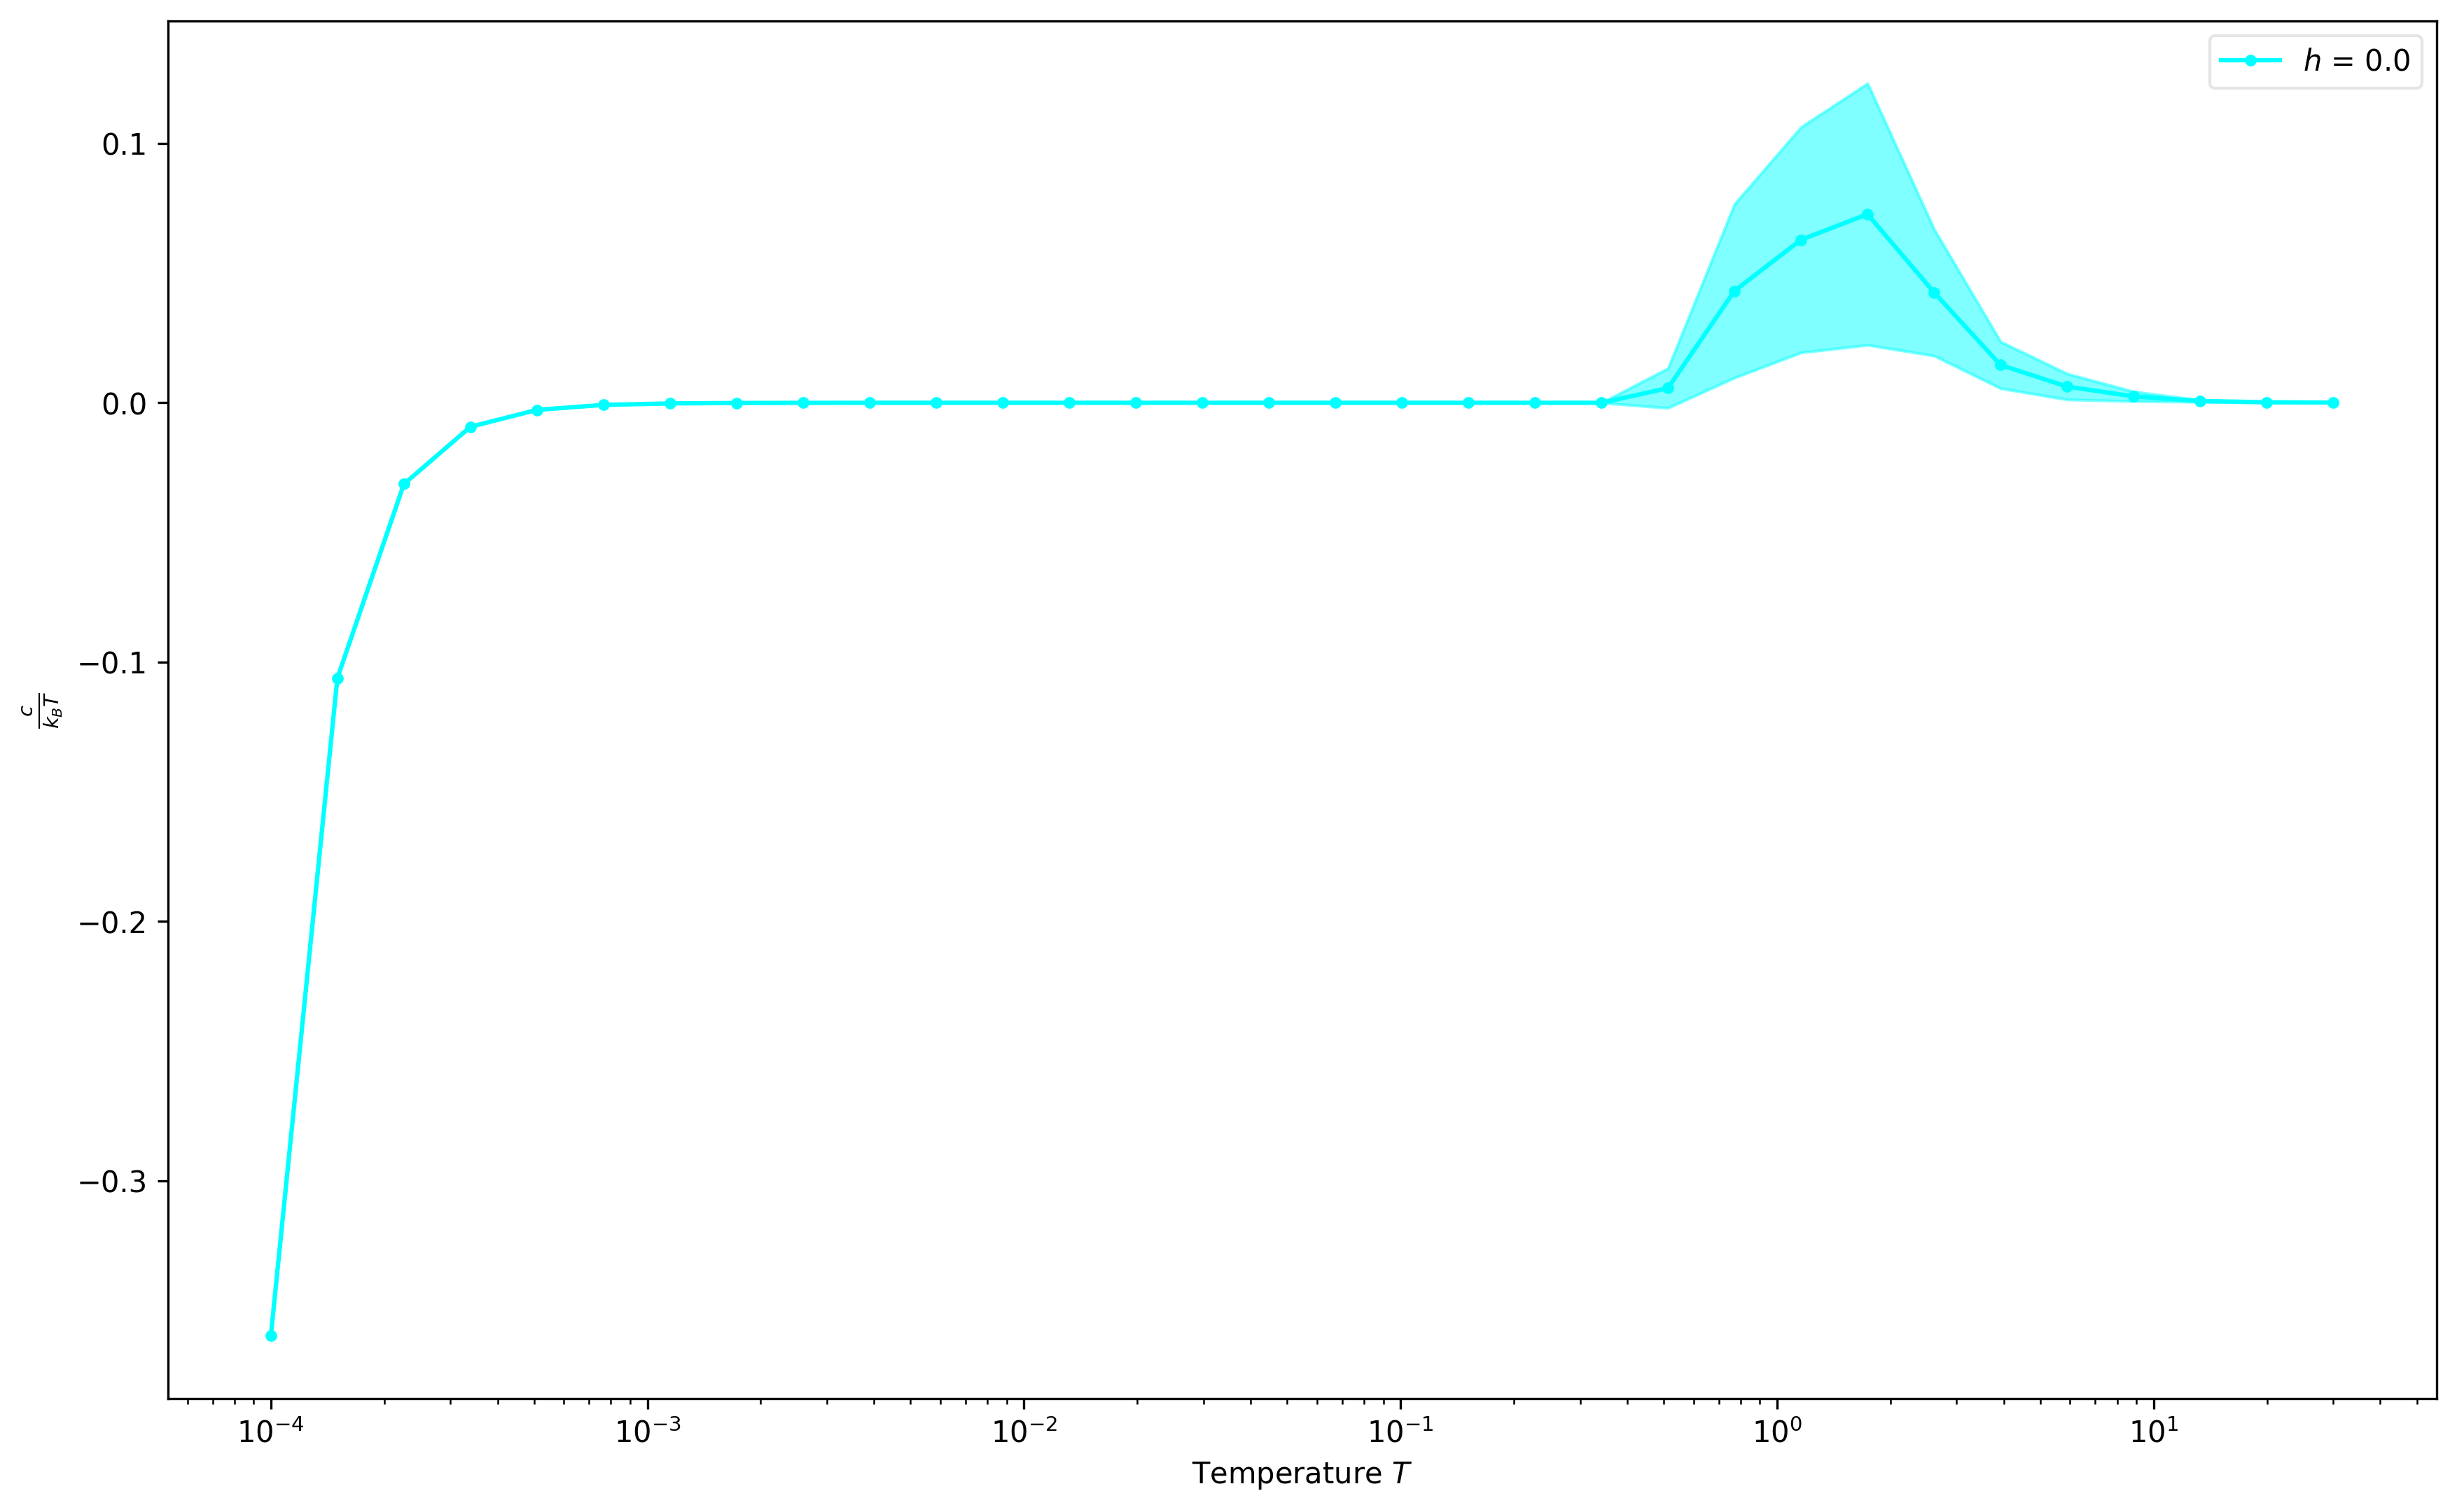

In [9]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
plt.show()

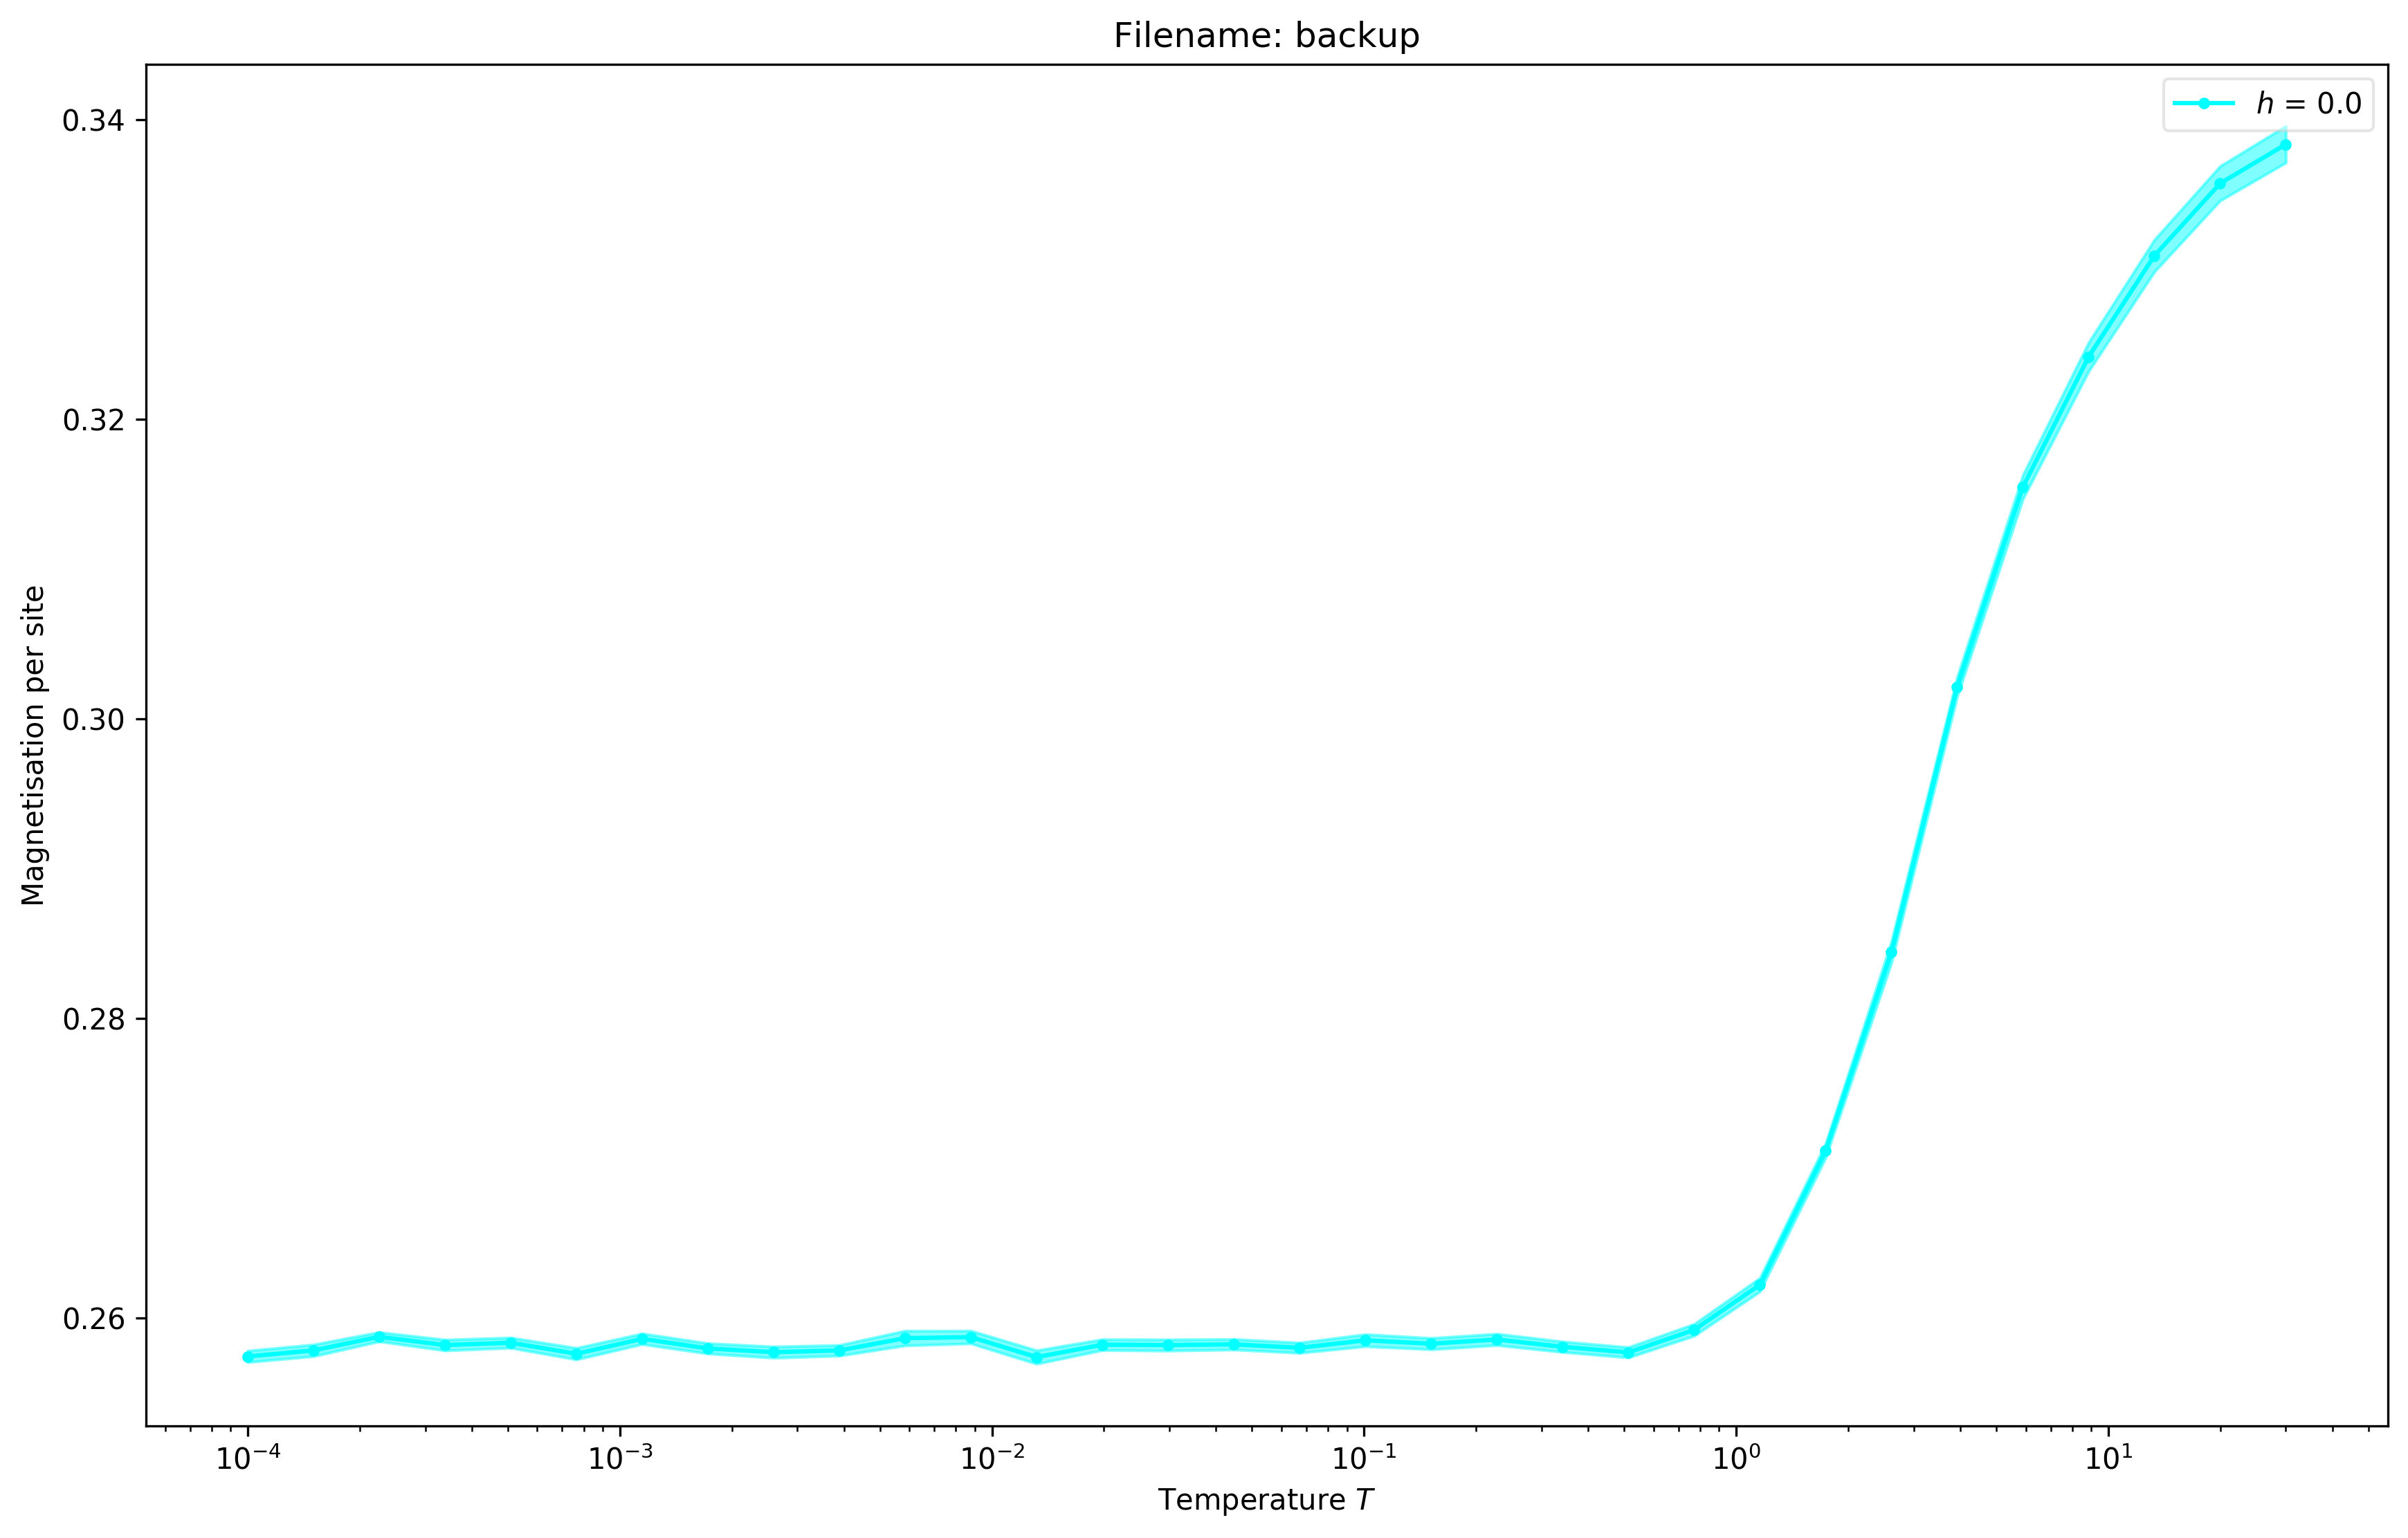

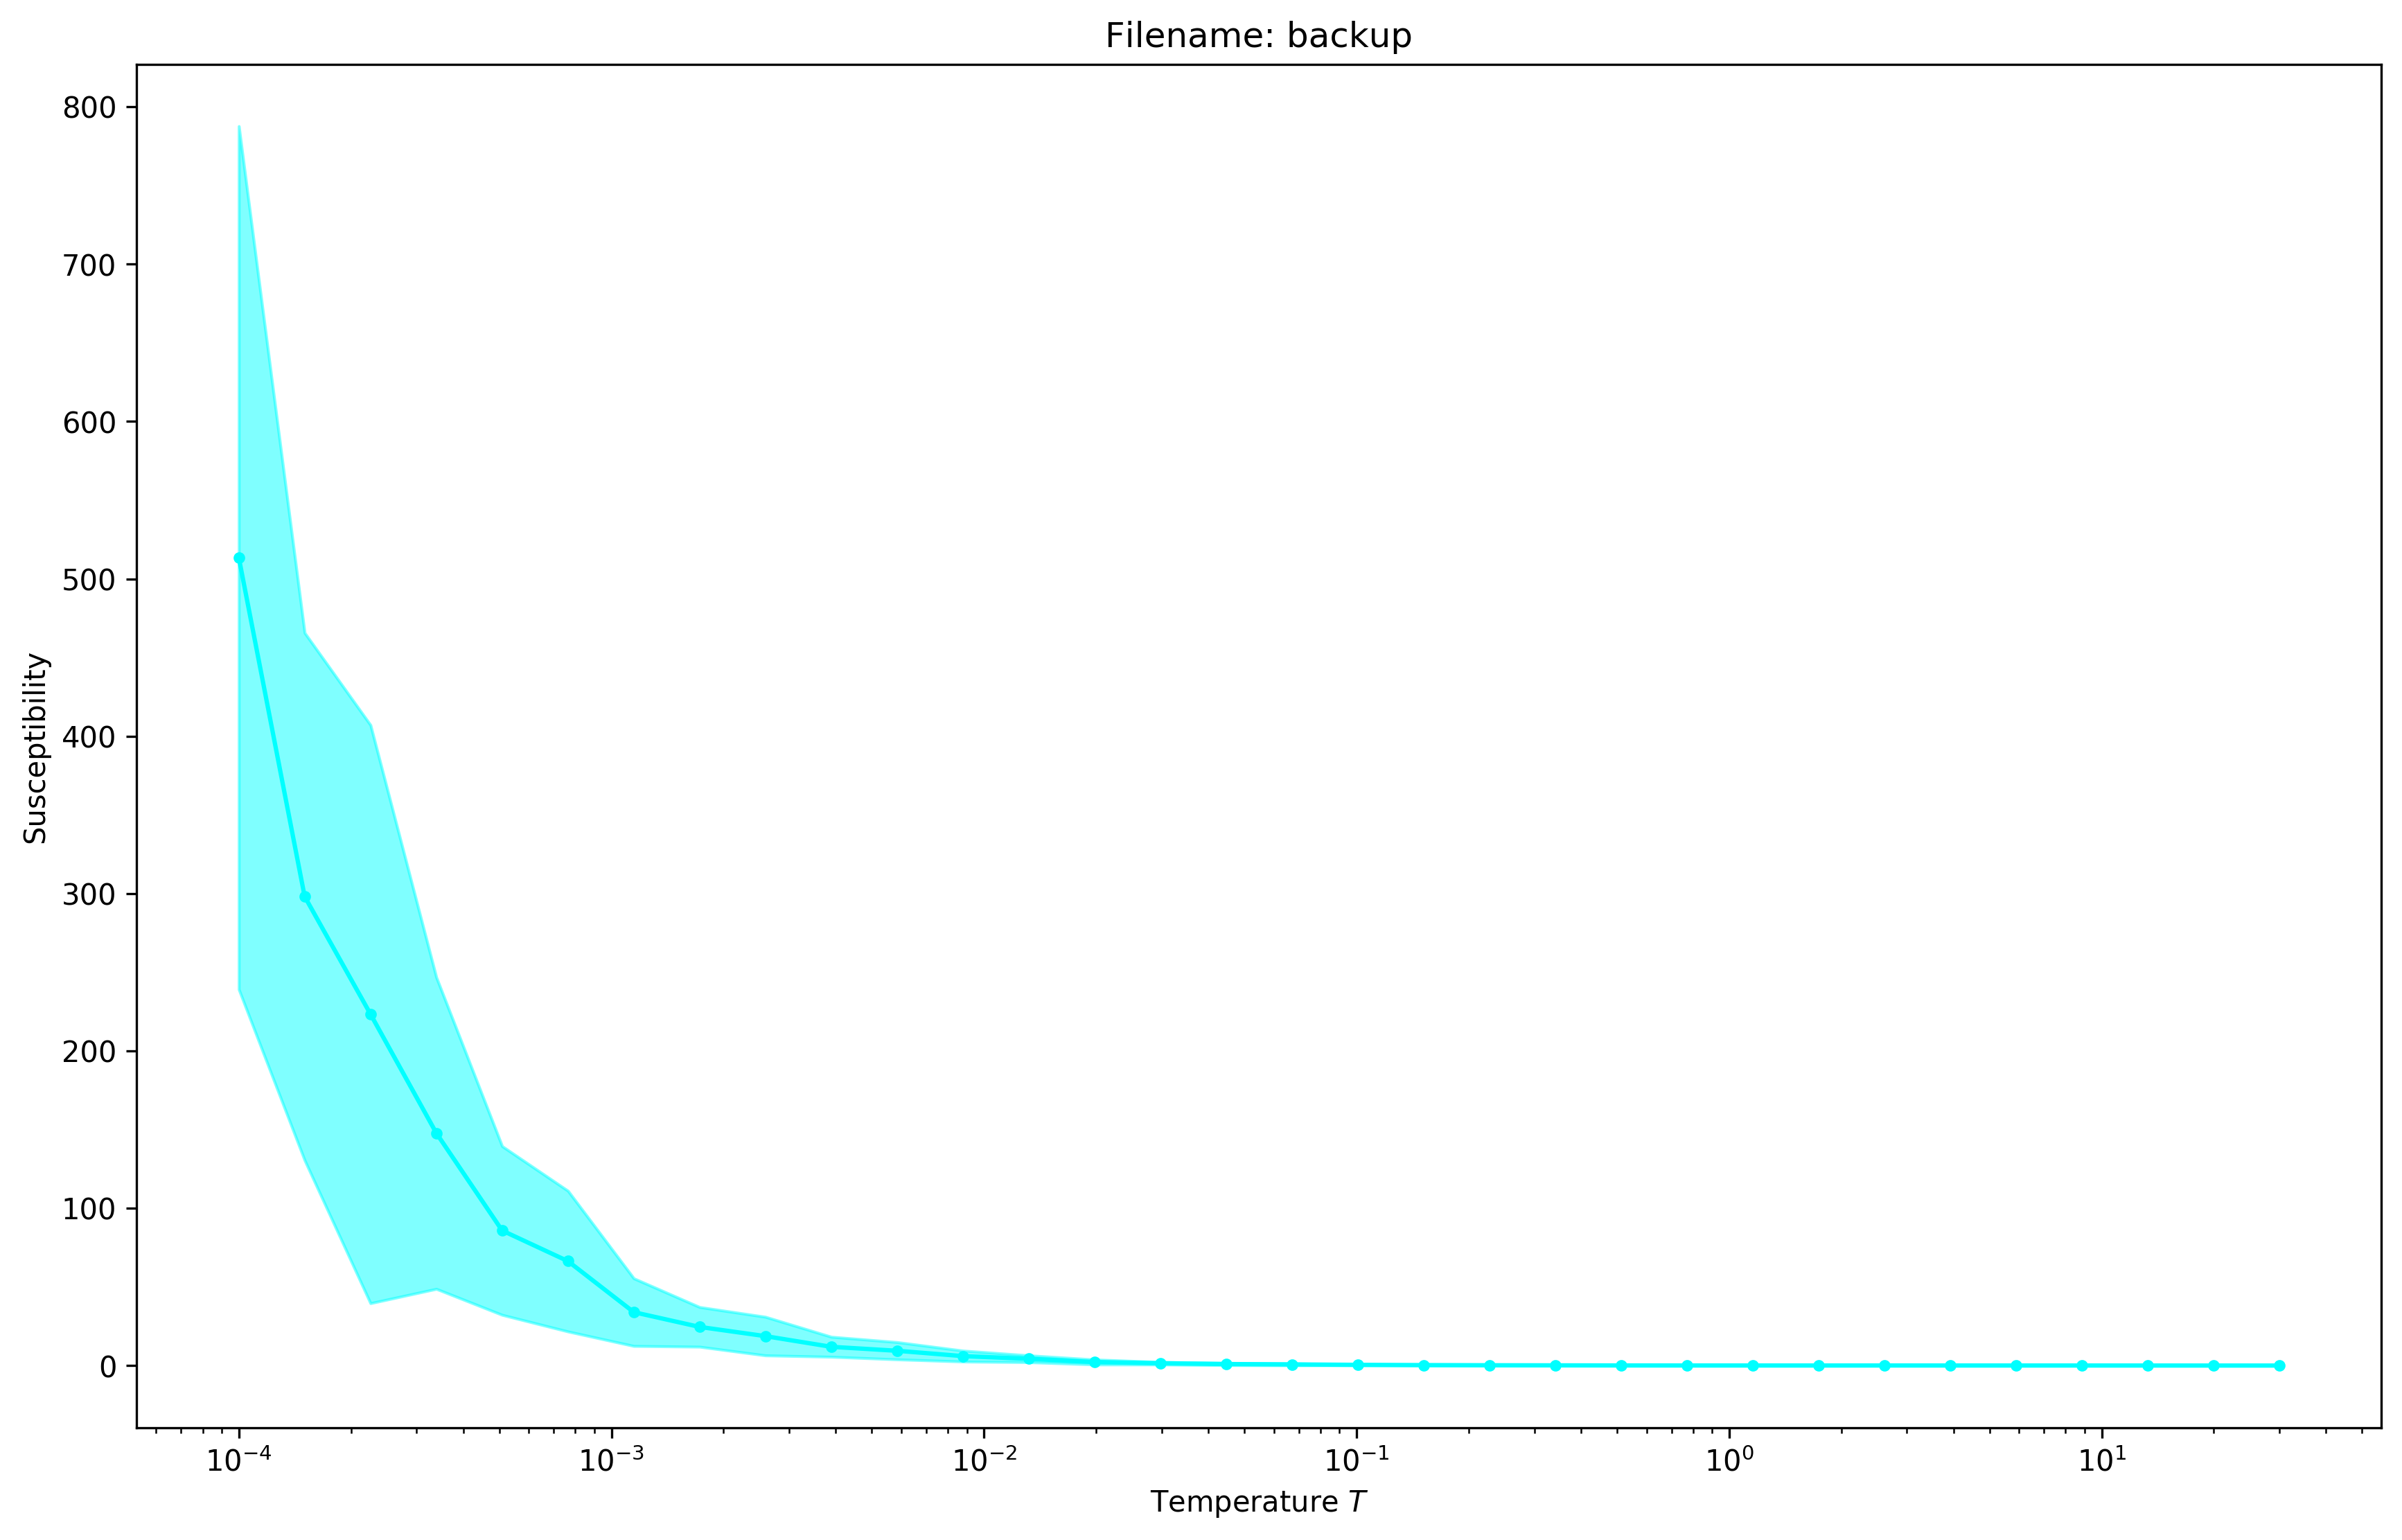

In [10]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanM, t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi] = \
 af.LoadMagnetisation(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsM(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanM, t_h_MeanMsq, t_h_varMeanM,
                t_h_varMeanMsq, Chi, ErrChi, J1, J2, J3, J4, **kw)
plt.show()

In [11]:
import importlib
importlib.reload(af)

<module 'AnalysisFunctions' from '/home/jcolbois/Documents/Codes_DipolarIsingModel/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py'>

In [12]:
t_h_MeanFc, t_h_varMeanFc, t_h_MeanSi, t_h_varMeanSi= \
 af.LoadFirstCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)


In [13]:
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,0],'.',label = 'NN')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,1],'.',label = 'NN2')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,2],'.',label = 'NN3par')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,3],'.',label = 'NN3star')
plt.title("p = {0}".format(p))
plt.xlabel("T")
plt.ylabel("Correlation")
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/FirstCorrelations.png")

TypeError: list indices must be integers or slices, not tuple

In [ ]:
t_h_MeanSs, t_h_varMeanSs, t_h_MeanSi, t_h_varMeanSi, t_h_MeanCorr, t_h_errCorrEstim = \
 af.LoadCentralCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)


In [ ]:
### COMPUTING CORRELATIONS FROM <SISJ> AND <SI> and plotting in 2D
ploth = False
if not ploth:
    tid = 0
    hid = 0
    rid = tid
else:
    tid = 9
    hid = 15
    rid = hid

[corr, errcorr, maxerr] = af.PrepPlot2DCorrelations(rid, n, 
                                                t_h_MeanCorr,
                                                t_h_errCorrEstim,
                                                t_h_MeanSi,
                                                hfields_plots,
                                                temperatures_plots,\
                                                ploth = ploth)
print("t = ",temperatures_plots[0][tid])
print("h = ",hfields_plots[0][hid])

In [ ]:
af.BasicPlotsCorrelations2D(foldername, results_foldername, rid,
                            n,L,corr,errcorr,
                            t_h_MeanSi, hfields_plots, 
                            temperatures_plots,
                            ploth = ploth)

In [ ]:
# Check structure factor:
import KagomeFT as kft #small functions to compute the FT


In [ ]:
i =0

StrctFact =\
kft.StrctFact(L[i],
              np.array(t_h_MeanCorr[i])[:,tid,hid,:],\
              centered = True, srefs = sref[i])
vmin = 1.5
vmax = 2.5

af.PlotStrctFact(StrctFact, foldername, results_foldername, tid,
                 hid, L, i, hfields_plots, temperatures_plots,
                 vmindiag = 0.4, vmaxdiag = 1.6,vminoff = -0.6, vmaxoff = 0.6)

In [ ]:
af.PlotFirstCorrelations(n, L,foldername, results_foldername,  hfields_plots, temperatures_plots,
                         t_h_MeanCorr, t_h_errCorrEstim,\
                         distmax = 2, ploth = ploth)

In [ ]:
c_1 = "red"
c_2 = "lightgreen"
c_3 = "green"
c_4 = "orange"
i = 0

In [ ]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_spinstates, t_states, t_charges] = \
 af.LoadStates(foldername, filenamelist, L, nh, **kw)
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d, d_nd, d_vd, d_wn,
 sidlist, didlist, c_ijl, ijl_c, c2s, csign] =\
dw.latticeinit(L[0])
#t_h_charges = np.array([obs.charges(len(s_ijl),[],[],
#                                         spinstate, s_ijl, ijl_s,c2s,
#                                         csign) for spinstate in t_spinstates[0]])
plt.figure(dpi=200, figsize=(10,10))
plt.axis('equal')
(s_ijl, ijl_s) = kdraw.createspinsitetable(L[0])
kdraw.plot_kag_spinstate(np.array(t_spinstates[0][i]), ijl_s, L[0], 2, 'lightblue', 'lightblue', 'peachpuff', linewidth = 1)
kdraw.plot_honeycomb_chargestate(t_charges[0][i], ijl_c, L[0], 2, c1_color = c_1, 
                                 c2_color = c_2, c3_color = c_3, c4_color = c_4)
plt.tick_params(  
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False,
    left = False,
    right = False,
    labelleft = False)
plt.legend()
plt.show()

In [ ]:
n = 0
[d_ijl, ijl_d, s_ijl, ijl_s, d_2s, s2_d,
 d_nd, d_vd, d_wn, sidlist, didlist,
 c_ijl, ijl_c, c2s, csign] = dw.latticeinit(L[n])

idstate = 0
plt.figure(dpi=300, figsize=(10,10))
kdraw.plotstate(idstate, L[n], d_ijl, ijl_s, sidlist, didlist, s2_d,
               t_states[n], t_spinstates[n],dim_node_color = 'orange',
                dim_color = "orange", no_dim_color = 'lightgrey')
plt.savefig("./" + foldername + "/TestState{0}.png".format(idstate))